# Lending Club

In [96]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

from scipy.stats import ttest_ind
import matplotlib.dates as mdates
from pandas_confusion import ConfusionMatrix
import statsmodels.api as sm

sns.set_style('white')

## Abstract

## Introduction

Crowdfunding has become a new and exciting way to get capitale and to invest. Lending club has jumped into the trend by offering loans with fixed interest rates and terms that the public can choose to invest in. Lending club screens the loans that are applied for and only 10% gets approved and is subsequently offered to the public. By investing a small proportion in many different loans investors can diversify their portfolio and in this way keep the default risk to a minimum (which is estimated by lending club to be 4%). For their services lending club asks a fee of 1%. For investors this is an interesting way to get profit on their investment since it supposedly gives more stable returns than the stock market and higher interest rates than a savings account. The profits depend on the interest rate and the default rate. Therefore it is interesting to see whether certain characteristics of the loan or the buyer give a bigger chance of default. Hence this might help investors to upgrade their profits.

Lending club has provided the public with their records via their website. A previous dataset was released that holds the records from 2007-2011 and there has also been a Kaggle contest with a preprocessed lending club dataset in the past. In April 2016 lending club has provided their 2007-2015 dataset through Kaggle as dataset, not as contest. This is the dataset we will be working on with in this project. Nevertheless, previous work has usually been done on one of the earlier releases of their dataset. While most earlier work has been focussed on predicting good loans from bad loans which we also will be focussing on, most have incorporated also the current loans. This holds a problem, since loans with a 'late' status could still recover and end in 'fully paid'. And 'current' loans could still end in the status 'charged off'. This is why we will focus only on loans that are closed and are therefore either 'fully paid' or 'charged off'. The consequence is that previous work that has incorporated these current loans is not completely comparable.

To predict whether a loan will end in 'charged off' we will use machine learning algorithms. According to previous work, both Logistic Regression and Random Forest have been found to work the best. Although work that incorporates no external datasets usually ends up with a Area Under the Curve (AUC)-score around 0.7. Which is not really great, but better than chance. The most important feature is usually found to be 'grade'. This is a measure for risk assesment of the loans given by Lending Club itself. The categories are A-G including subcategories like A1 etc. The idea is that the closer to G the higher the chance on default. Usually the interest rate is also higher for the riskier loans in order to make these loans still attractive for investors. 

In this project, we will first focus on exploring the data. We will see whether Lending Club is right about their claimed 4% default rate. Subsequently, we will see whether loans with higher grades have indeed higher interest rates and higher default rates. And we will close the exploration part with how profitable the loans with the different grade categories actually are on average. Hereafter we will move on to the prediction part. Where we will use Random Forest and Logistic Regression to predict the 'charged off' from the 'fully paid' loans. We will see if an algorithm with just grade performs just as good as an algorithm with all features. Hence that adding features gives no benefit from the metric Lending Club already provides. Furthermore, we will try to recreate grade from the features, to see whether Lending Club provides the features they use for their algorithm and which features are important because they are used to create grade. And finally, we will see whether return of investment increases with our algorithm and whether we can give some tips to the lending club investors.

## Methods

### Dataset

For this project the Lending Club dataset from Kaggle was used (https://www.kaggle.com/wendykan/lending-club-loan-data). This file contains complete loan data for loans issued between 2007 and 2015. There are 887,379 loans in the file and 74 features. A self created feature ROI was added, but this is not part of the dataset. A couple of features have to do with the loan (32) and a couple have to do with the one that's asking for the loan (42). The feature we are intested in to predict is 'loan status'. In this case we are only interested in loans that went to full term. Hence we selected the loans that had either status 'fully paid' or 'charged off'. Statusses 'issued', 'current', 'default', 'late (31-120 days)', 'late (16-30 days)' and 'in grace period' are loans that are still ongoing for which you cannot be certain yet how they ended. 'Does not meet credit policy' loans would not be issued today, so are not useful for future investors. In all the loans 5% has the status 'charged off'. After selecting only the loans that went to full term, we are left with 252,971 loans. This is 28.5% of the number of loans we started with. Of these 18% have the status 'charged off'.

In [2]:
loans = pd.read_csv('../data/loan.csv')
loans['roi'] = ((loans['total_rec_int'] + loans['total_rec_prncp'] 
                          + loans['total_rec_late_fee'] + loans['recoveries']) / loans['funded_amnt']) - 1
print('loans:',loans.shape)
print(loans['loan_status'].unique())
print('percentage charged off in all loans:', 
      round(sum(loans['loan_status']=='Charged Off')/len(loans['loan_status'])*100), '\n')

# selecting loans that went to full term
closed_loans = loans[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]
print('closed_loans:',closed_loans.shape)
print('precentage closed loans of total loans:', round(closed_loans.shape[0] / loans.shape[0] * 100, 1))
print('percentage charged off in closed loans:', 
      round(sum(closed_loans['loan_status']=='Charged Off')/len(closed_loans['loan_status'])*100))

loans: (887379, 75)
['Fully Paid' 'Charged Off' 'Current' 'Default' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off' 'Issued']
percentage charged off in all loans: 5.0 

closed_loans: (252971, 75)
precentage closed loans of total loans: 28.5
percentage charged off in closed loans: 18.0


/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Preprocessing

We want to give advice to investors which loans they should invest in. Therefore we selected for the prediction only the features that are known before the investors pick the loans they want to invest in. Also we deleted features that are not useful for prediciton like 'id' and features that have all the same values. There was only one 'joint' loan application, while all others where individual loans. Hence we deleted this one loan also. If a feature had more than 10% missing features we deleted this feature from the features used for prediction. Moreover rows that had a missing value in one of the remaining features were deleted. The features 'earliest creditline' and 'issue date' were transformed to one feature, namely the number of days between the earliest creditline and the issue date of the loan (Rpub). The values in the feature annual income were divided by 1000 and rounded-up in order to get more similar values and outliers (above 200,000) were transformed to 200,000. After these tranformation we are left with 252,771 loans and 23 features and the percentage of 'charged off' loans is still 18%. We kept our self created 'roi' feature for data exploration purposes, but this is not a feature we will use for prediction and it will be excluded later.

In [3]:
include = ['term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 
          'annual_inc', 'purpose', 'zip_code', 'addr_state', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 
          'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 
          'mths_since_last_major_derog', 'acc_now_delinq', 'loan_amnt', 'open_il_6m', 'open_il_12m', 
          'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'dti', 'open_acc_6m', 'tot_cur_bal',
          'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl',
          'inq_last_12m', 'issue_d', 'loan_status', 'roi']

# exclude the one joint application
closed_loans = closed_loans[closed_loans['application_type'] == 'INDIVIDUAL']

# make id index
closed_loans.index = closed_loans.id

# include only the features above
closed_loans = closed_loans[include]

# exclude features with more than 10% missing values
columns_not_missing = (closed_loans.isnull().apply(sum, 0) / len(closed_loans)) < 0.1
closed_loans = closed_loans.loc[:,columns_not_missing[columns_not_missing].index]

# delete rows with NANs
closed_loans = closed_loans.dropna()

# calculate nr of days between earliest creditline and issue date of the loan
# delete the two original features
closed_loans['earliest_cr_line'] = pd.to_datetime(closed_loans['earliest_cr_line'])
closed_loans['issue_d'] = pd.to_datetime(closed_loans['issue_d'])
closed_loans['days_since_first_credit_line'] = closed_loans['issue_d'] - closed_loans['earliest_cr_line']
closed_loans['days_since_first_credit_line'] = closed_loans['days_since_first_credit_line'] / np.timedelta64(1, 'D')
closed_loans = closed_loans.drop(['earliest_cr_line', 'issue_d'], axis=1)

# round-up annual_inc and cut-off outliers annual_inc at 200.000
closed_loans['annual_inc'] = np.ceil(closed_loans['annual_inc'] / 1000)
closed_loans.loc[closed_loans['annual_inc'] > 200, 'annual_inc'] = 200

print(closed_loans.shape)
print('percentage charged off in closed loans:', 
      round(sum(closed_loans['loan_status']=='Charged Off') / len(closed_loans['loan_status']) * 100))

(252771, 24)
percentage charged off in closed loans: 18.0


The selected features:
- term: the number of payments on the loan. Values are in months and can be either
36 or 60
- int_rate: interest rate
- installment: height monthly pay
- grade: A-G, A low risk, G high risk
- sub_grade: A1-G5
- emp_length: 0-10 years (10 stands for >=10)
- home_ownership: 'RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE' and 'ANY'
- annual_inc: annual income stated by borrower, divided by 1000 and rounded-up, 200 stand for >=200,000
- purpose: 'credit_card', 'car', 'small_business', 'other', 'wedding', 'debt_consolidation', 'home_improvement', 'major_purchase', 'medical', 'moving', 'vacation', 'house', 'renewable_energy' and 'educational'
- zip_code: first 3 numbers followed by 2 times x
- addr_state: two letters representing the state the borrower lives in
- delinq_2yrs: the number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
- inq_last_6mths: the number of inquiries by creditors during the past 6 months
- open acc: the number of open credit lines in the borrower’s credit file
- pub_rec: number of derogatory public records
- revol_bal: total credit revolving balance
- revol_util: revolving line utilization rate, or the amount of credit the borrower is using
relative to all available revolving credit
- total_acc: the total number of credit lines currently in the borrower’s credit file
- acc_now_delinq: the number of accounts on which the borrower is now delinquent
- loan_amnt: the listed amount of the loan applied for by the borrower
- dti: a ratio calculated using the borrower’s total monthly debt payments on the
total debt obligations, excluding mortgage and the requested LC loan, divided
by the borrower’s self-reported monthly income
- loan_status: the listed amount of the loan applied for by the borrower
- days_since_first_credit_line: self created feature, days between earliest creditline and issue date

In [4]:
closed_loans.columns

Index(['term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'purpose', 'zip_code', 'addr_state',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'acc_now_delinq', 'loan_amnt', 'dti',
       'loan_status', 'roi', 'days_since_first_credit_line'],
      dtype='object')

In sklearn the features have to be numerical that we input in this algorithm, so we need to convert the categorical features to numeric. To do this ordered categorical features will have adjacent numbers and unordered features will get an order as best as possible during conversion to numeric, for instance geographical. Also there cannot be nan/inf/-inf values, hence these will be made 0's. With this algorithm we will also have to scale and normalize the features.
Non-numeric features were converted as follows:
- grade/sub_grade: order of the letters was kept
- emp_length: nr of years
- zipcode: numbers kept of zipcode (geographical order)
- term: in months
- home_ownership: from none/any/other to rent to mortgage to owned
- purpose: from purposes that might make money to purposes that only cost money
- addr_state: ordered geographically from west to east, top to bottom (https://theusa.nl/staten/)

In [5]:
# features that are not float or int, so not to be converted:

# ordered:
# sub_grade, emp_length, zip_code, term

# unordered:
# home_ownership, purpose, addr_state (ordered geographically)

closed_loans_predict = closed_loans.copy()

# term
closed_loans_predict['term'] = closed_loans_predict['term'].apply(lambda x: int(x.split(' ')[1]))

# grade
closed_loans_predict['grade'] = closed_loans_predict['grade'].astype('category')
grade_dict = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
closed_loans_predict['grade'] = closed_loans_predict['grade'].apply(lambda x: grade_dict[x])

# emp_length
emp_length_dict = {'n/a':0,
                   '< 1 year':0,
                   '1 year':1,
                   '2 years':2,
                   '3 years':3,
                   '4 years':4,
                   '5 years':5,
                   '6 years':6,
                   '7 years':7,
                   '8 years':8,
                   '9 years':9,
                   '10+ years':10}
closed_loans_predict['emp_length'] = closed_loans_predict['emp_length'].apply(lambda x: emp_length_dict[x])

# zipcode
closed_loans_predict['zip_code'] = closed_loans_predict['zip_code'].apply(lambda x: int(x[0:3]))

# subgrade
closed_loans_predict['sub_grade'] = (closed_loans_predict['grade'] 
                                    + closed_loans_predict['sub_grade'].apply(lambda x: float(list(x)[1])/10))

# house
house_dict = {'NONE': 0, 'OTHER': 0, 'ANY': 0, 'RENT': 1, 'MORTGAGE': 2, 'OWN': 3}
closed_loans_predict['home_ownership'] = closed_loans_predict['home_ownership'].apply(lambda x: house_dict[x])

# purpose
purpose_dict = {'other': 0, 'small_business': 1, 'renewable_energy': 2, 'home_improvement': 3,
                'house': 4, 'educational': 5, 'medical': 6, 'moving': 7, 'car': 8, 
                'major_purchase': 9, 'wedding': 10, 'vacation': 11, 'credit_card': 12, 
                'debt_consolidation': 13}
closed_loans_predict['purpose'] = closed_loans_predict['purpose'].apply(lambda x: purpose_dict[x])

# states
state_dict = {'AK': 0, 'WA': 1, 'ID': 2, 'MT': 3, 'ND': 4, 'MN': 5, 
              'OR': 6, 'WY': 7, 'SD': 8, 'WI': 9, 'MI': 10, 'NY': 11, 
              'VT': 12, 'NH': 13, 'MA': 14, 'CT': 15, 'RI': 16, 'ME': 17,
              'CA': 18, 'NV': 19, 'UT': 20, 'CO': 21, 'NE': 22, 'IA': 23, 
              'KS': 24, 'MO': 25, 'IL': 26, 'IN': 27, 'OH': 28, 'PA': 29, 
              'NJ': 30, 'KY': 31, 'WV': 32, 'VA': 33, 'DC': 34, 'MD': 35, 
              'DE': 36, 'AZ': 37, 'NM': 38, 'OK': 39, 'AR': 40, 'TN': 41, 
              'NC': 42, 'TX': 43, 'LA': 44, 'MS': 45, 'AL': 46, 'GA': 47, 
              'SC': 48, 'FL': 49, 'HI': 50}
closed_loans_predict['addr_state'] = closed_loans_predict['addr_state'].apply(lambda x: state_dict[x])

# make NA's, inf and -inf 0
closed_loans_predict = closed_loans_predict.fillna(0)
closed_loans_predict = closed_loans_predict.replace([np.inf, -np.inf], 0)

### Classification

We selected two algorithms to use for this project based on that they preformed the best on Lending Club datasets: Logistic Regression and Random Forest. The Logistic Regression classifier is a simple classifier that uses a sigmoidal curve to predict from the features to which class the sample belongs. It has one parameter to tune namely the C-parameter. This is the inverse of the regularization strength, smaller values specify stronger regularization. We will be using l1/lasso-regularization in the case of multiple features. With this algorithm we will also have to scale and normalize the features. Sometimes this algorithm has been found to perform better with less features on a Lending Club dataset.

Random Forest is a more complicated algorithm that scores well in a lot of cases. This algorithm makes various decision trees from subsets of the samples and uses at each split only a fraction of the features to prevent overfitting. The Random Forest algorithm is known to be not very sensitive to the values of its parameters: the number of features used at each split and the number of trees in the forest. Nevertheless, the default of sklearn is so low that we will raise the number of trees to 100. The algorithm has feature selection already builtin (at each split) and scaling/normalization is also not necessary.

For the classification we will split the data in a train (70%) and a test set (30%). The test set is used to evaluate the performance of our classifier.

In [6]:
# split data in train (70%) and test set (30%)
X_train, X_test, y_train, y_test = train_test_split(closed_loans_predict.drop(['loan_status', 'roi'], axis=1), 
                                                    closed_loans_predict['loan_status'], 
                                                    test_size=0.3, random_state=123)

# scaling and normalizing the features
X_train_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# scale test set with scaling used in train set
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

### Performance metrics

We will use a few metrics to test the performance of our classifier on the test set. First we will use confusion matrices and their statistics. A confusion matrix shows how many true negatives (TN), false positives (FP), false negatives (FN) and true positives (TP). Secondly, we will use the F-score. This is implemented as 'f1_weighted' in sklearn. This score can be interpreted as a weighted average of the precision and recall. Precision is defined as TP / (TP + FP), while recall is defined as TP / (TP + FN). The F-score is supposed to deal better with classes of unequal size, as is the case in this project, than the standard accuracy metric, which could become really high if the algorithm only predicts the dominant class. Thirdly, we will show Receiver Operating Characteristic (ROC) curves which deal very well with unequal sized classes. The Area Under the Curve (AUC)-score of the ROC-plot is always 0.5 for random result and above 0.5 for a better than random result with 1.0 as maximum score. And lastly, from the Stanford paper we will use teir definition of return-of-investment on a loan to represent how profitable a loan is. Their definition is ROI = (Total payment received by investors / Total amount committed by investors) − 1. 

## Results

### Exploration

Lending Club claims that the default rate of their loans 4% is. We checked this out in the complete set we used for this project. And we found a 'charged off' rate (their default loan status) to be 5%. Hence a little higher than that they claimed, but not too much. But in this set there are a lot of loans that are still ongoing. For these loans you do not know whether they will end up in 'fully paid' or 'charged off'. Therefore we focus on loans that are closed. Of these loans a much higher percentage ends up in 'charged off', namely 18%. 

In [7]:
print('percentage charged off in all loans:', 
      round(sum(loans['loan_status']=='Charged Off')/len(loans['loan_status'])*100), '\n')
print('percentage charged off in closed loans:', 
      round(sum(closed_loans['loan_status']=='Charged Off') / len(closed_loans['loan_status']) * 100))

percentage charged off in all loans: 5.0 

percentage charged off in closed loans: 18.0


Lending Club gives grades (A-G) to their loans so potential investors can see which of these loans are not so risky (A) and which are the riskier loans (G). To make it still worthwhile to invest in the riskier loans, investors supposedly get more interest on these loans. From the Figure below we see that indeed the interest grade is higher for riskier loans, but that there are a few exceptions. 

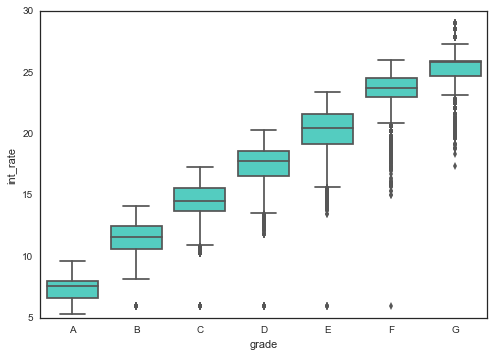

In [8]:
closed_loans['grade'] = closed_loans['grade'].astype('category', ordered=True)
sns.boxplot(data=closed_loans, x='grade', y='int_rate', color='turquoise')

Apart from grade and interest rate there are of course other characteristics of the loans. A few of them are shown below. We see that loans are in the range of almost 0 until 35,000. Hence Lending Club loans seem to be an alternative for personal loans and credit cards and not mortgages. The loans are either 36 months (3 years) or 60 months (5 years) and mostly 3 years. The purpose of the loan is mostly debt consolidation and credit card. Therefore it seems to be mostly people that already have debts. The annual income was cut-off at 200,000 but lies mostly between 25,000 and 100,000. 

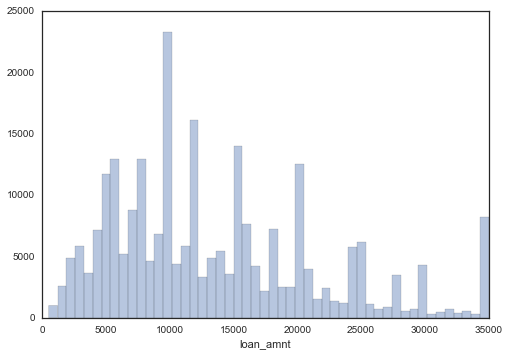

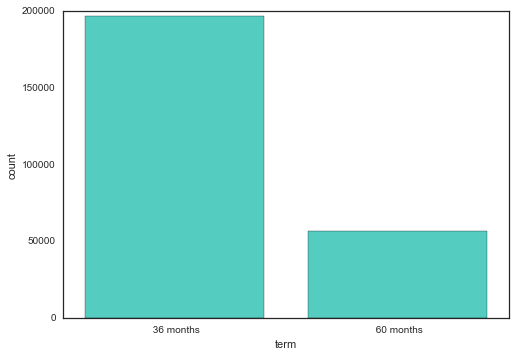

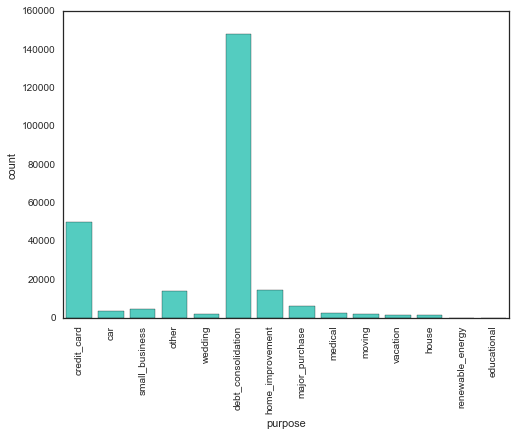

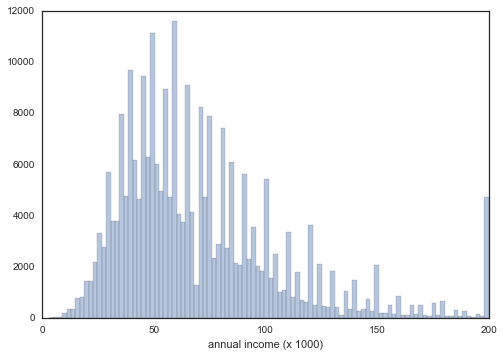

In [9]:
sns.distplot(closed_loans['loan_amnt'], kde=False, bins=50)
plt.show()
sns.countplot(closed_loans['term'], color='turquoise')
plt.show()
sns.countplot(closed_loans['purpose'], color='turquoise')
plt.xticks(rotation=90)
plt.show()
ax = sns.distplot(closed_loans['annual_inc'], bins=100, kde=False)
plt.xlim([0,200])
ax.set(xlabel='annual income (x 1000)')
plt.show()

We can speculate that some of the characteristics of loans have an influence on the loan ending up in 'charged off'. A first logical check is of course whether the Lending Club 'grade' is already visually a factor in loans ending up in this status. As we can see from the Figure below, the 'grade' is almost linearly correlated to the 'charged off proportion' of the loans. Only between F and G the difference is smaller. Hence Lending Club has a built a pretty good algorithm to predict the 'charged off' status. Also higher interest loans seem to end up in 'charged off' more often as excpected. Furthermore, with purpose the influence is not clearly visible. But with dti (debt-to-income) the difference is significant. This means the more debt a person has compared to their income, the more chance on the loan ending in 'charged off'. Lastly, with home ownership status the difference is visually present and also in numbers 'rent' has the highest charged off proportion, then 'own' and then 'mortgage'.  

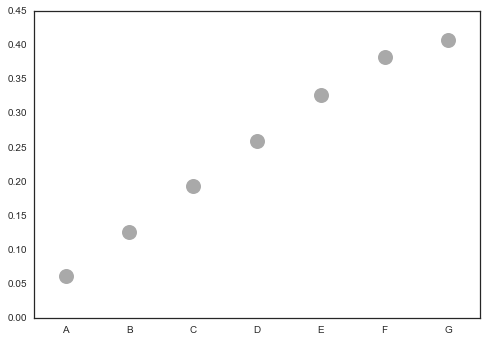

/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


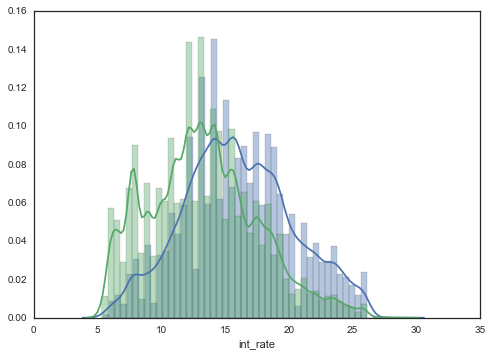

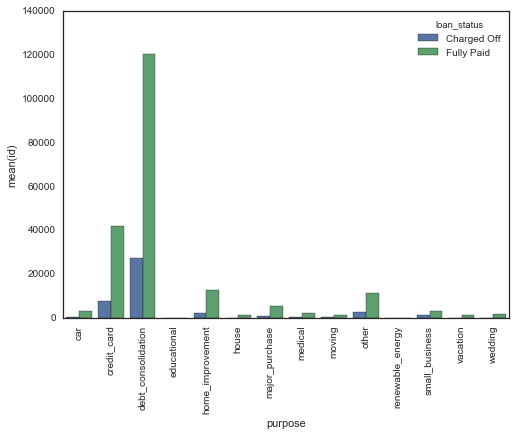

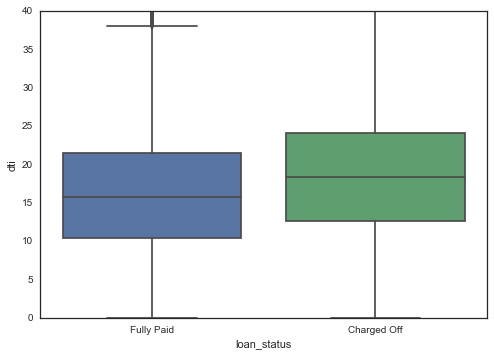

Ttest_indResult(statistic=-56.448263930658023, pvalue=0.0)
16.1410641711
18.4084456096


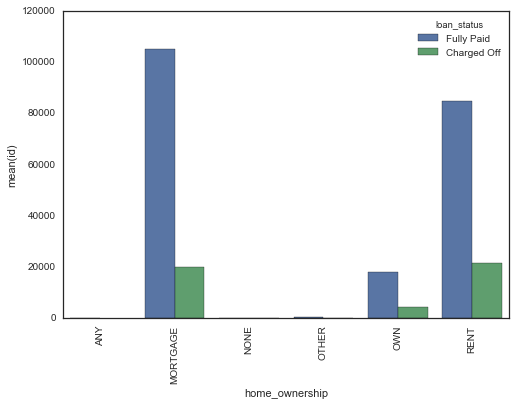

home_ownership  loan_status
ANY             Fully Paid          1
MORTGAGE        Charged Off     19860
                Fully Paid     104895
NONE            Charged Off         7
                Fully Paid         36
OTHER           Charged Off        27
                Fully Paid        112
OWN             Charged Off      4018
                Fully Paid      17946
RENT            Charged Off     21289
                Fully Paid      84580
Name: id, dtype: int64
mortgage: 0.159192016352
own: 0.182935712985
rent: 0.201088137226


In [10]:
grade_status = closed_loans.reset_index().groupby(['grade', 'loan_status'])['id'].count()
risk_grades = dict.fromkeys(closed_loans['grade'].unique())
for g in risk_grades.keys():
    risk_grades[g] = grade_status.loc[(g, 'Charged Off')] / (grade_status.loc[(g, 'Charged Off')] + grade_status.loc[(g, 'Fully Paid')])
risk_grades = pd.DataFrame(risk_grades, index=['proportion_unpaid_loans'])    
sns.stripplot(data=risk_grades, color='darkgray', size=15)
plt.show()

sns.distplot(closed_loans[closed_loans['loan_status']=='Charged Off']['int_rate'])
sns.distplot(closed_loans[closed_loans['loan_status']=='Fully Paid']['int_rate'])
plt.show()

purpose_paid = closed_loans.reset_index().groupby(['purpose', 'loan_status'])['id'].count()
sns.barplot(data=pd.DataFrame(purpose_paid).reset_index(), x='purpose', y='id', hue='loan_status')
plt.xticks(rotation=90)
plt.show()

sns.boxplot(data=closed_loans, x='loan_status', y='dti')
plt.show()
print(ttest_ind(closed_loans[closed_loans['loan_status']=='Fully Paid']['dti'], 
                closed_loans[closed_loans['loan_status']=='Charged Off']['dti']))
print((closed_loans[closed_loans['loan_status']=='Fully Paid']['dti']).mean())
print((closed_loans[closed_loans['loan_status']=='Charged Off']['dti']).mean())

home_paid = closed_loans.reset_index().groupby(['home_ownership', 'loan_status'])['id'].count()
sns.barplot(data=pd.DataFrame(home_paid).reset_index(), x='home_ownership', y='id', hue='loan_status')
plt.xticks(rotation=90)
plt.show()

print(home_paid)
print('mortgage:', home_paid['MORTGAGE'][0] / (home_paid['MORTGAGE'][0] + home_paid['MORTGAGE'][1]))
print('own:', home_paid['OWN'][0] / (home_paid['OWN'][0] + home_paid['OWN'][1]))
print('rent:', home_paid['RENT'][0] / (home_paid['RENT'][0] + home_paid['RENT'][1]))

Another interesting question is whether it is profitable to invest in loans from Lending Club and whether the 'grade' is of influence in this. Herefore we will show the return-of-investment (ROI) overall and per grade. As is seen below the loans have an average of only 1.4% profit. And if we look per grade only A-C will result in profit on average. Loans that end up in 'charged off' are on average very bad for the profits since you will likely loose part of the principal as well. In the A-C categories the loans end up in 'charged off' less times and are therefore on average more profitable even though the loans in the riskier categories deliver more interest returns. The higher interest (more than 20% in the riskiest grades) does not compensate enough for the high 'charged off' ratio, which is around 40% in the riskiest grades as we saw before.

grade
A    0.044555
B    0.046401
C    0.012001
D   -0.016277
E   -0.061398
F   -0.085575
G   -0.104552
Name: roi, dtype: float64
0.013866103562


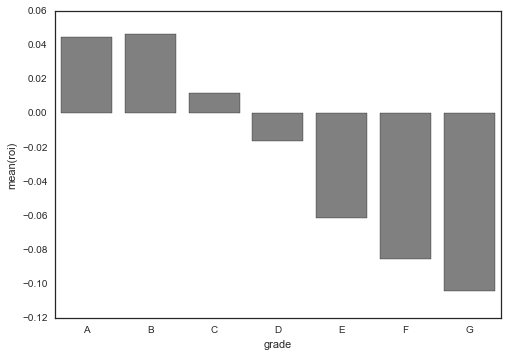

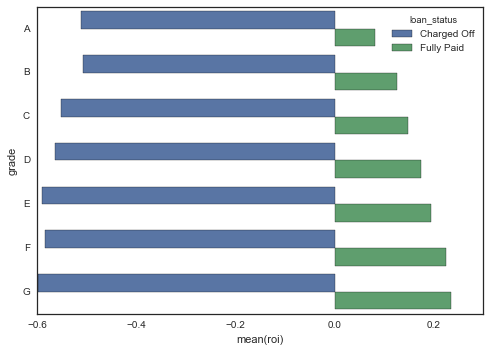

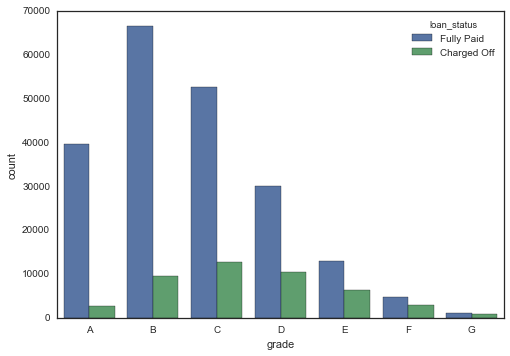

In [15]:
roi = closed_loans.groupby('grade')['roi'].mean()
print(roi)
print(closed_loans['roi'].mean())
sns.barplot(data=roi.reset_index(), x='grade', y='roi', color='gray')
plt.show()
roi = closed_loans.groupby(['grade', 'loan_status'])['roi'].mean()
sns.barplot(data=roi.reset_index(), x='roi', y='grade', hue='loan_status', orient='h')
plt.show()
sns.countplot(data=closed_loans, x='grade', hue='loan_status')
plt.show()

### Prediction

#### Predicting status 'charged off'

As we saw in the exploration part. The 'grade' is already a pretty good characteristic to predict 'charged off' rate. Therefore we will first see whether adding any additional features is actually useful. Subsequently we will see if we can recreate 'grade' from the features to see which features are still useful but incorporated in 'grade'. In the methods is described which features were selected. We excluded all features not known at the start of the loan and features that are not predictive like the id of the loan or have a lot of missing values. Twentythree of the features remain in this way. Logistic Regression and Random Forest, two algorithms that have performed well in the past on this dataset, will be used for the prediction. For optimal performance of the Logistic Regression algorithm, the C-parameter can be tuned (the inverse of the regularization strength) on the training set. This is only necessary in the case of using multiple features, because regularization is not useful in the case of one feature (grade in this case). The found optimal value for the C-parameter on the training set is 10.

In [19]:
# parameter tuning Logistic Regression
dict_Cs = {'C': [0.001, 0.1, 1, 10, 100]}
clf = GridSearchCV(LogisticRegression(penalty='l1'), dict_Cs, 'f1_weighted', cv=10)

#clf.fit(X_train_scaled, y_train)
#print(clf.best_params_)
#print(clf.best_score_)

We trained both our classifiers on both only 'grade' and all features. And with Logistic Regression we also trained one with top-5 features as selected by SelectKBest from sklearn. This is because Logistic Regression sometimes performs better with less features. We see that all F-scores are around 0.75. Using all features instead of only grade gives only a very marginal increase of around 1% and using 5 features gives not increase. The best performing algorithm based on the F-score is Logistic regression with all features. But the differences were very small. When looking at the confusion matrices it is clear that all algorithms mostly predict 'Fully Paid', since this is the dominant class (82%) accuracy scores will look pretty well, while the algorithm is actually not that great as can be seen from the confusion matrices. The F-score metric was chosen based on the fact that it can deal better with unequal classes, but even that reports an score of 0.74 when Random Forest predicts all loans to be 'Fully Paid'. AUC is in this case a better metric, since also with uneven classes random remains 0.5. The algorithms with only grade give an AUC of 0.66. While the Logistic Regression with all features gives a score of 0.71 and Random Forest of 0.7. The top-5 features algorithm is in between those with 0.68. Hence again adding all features gives a little better performance (0.4-0.5) and Logistic Regression with all features performs the best. In the ROC-plot this is also displayed. 

f1_score: 0.746041404442
auc: 0.66
Confusion Matrix:

Predicted    Charged Off  Fully Paid  __all__
Actual                                       
Charged Off          236       13302    13538
Fully Paid           330       61964    62294
__all__              566       75266    75832


Overall Statistics:

Accuracy: 0.82023420192
95% CI: (0.81748234524080143, 0.82296153591534582)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.0194151995092
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                               Charged Off  Fully Paid
Population                                  75832       75832
P: Condition positive                       13538       62294
N: Condition negative                       62294       13538
Test outcome positive                         566       75266
Test outcome negative                       75266         566
TP: True Positive                             236       61964
TN: True Negative                           61964         23

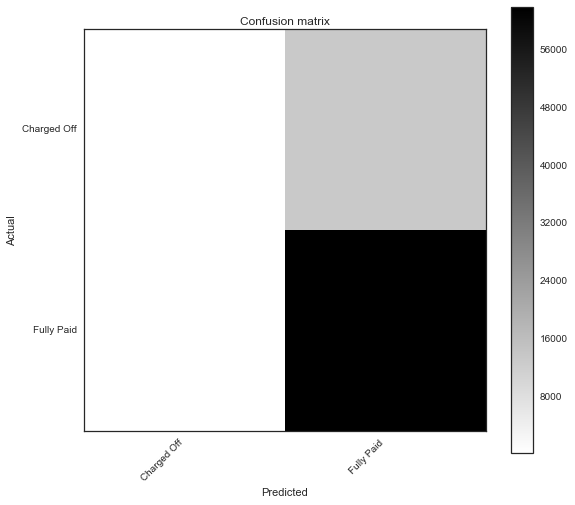

In [61]:
# Logistic Regression only grade
clf = LogisticRegression(penalty='l1', C=10)
clf.fit(X_train_scaled.loc[:,['grade']], y_train)
prediction = clf.predict(X_test_scaled.loc[:,['grade']])

# F1-score
print('f1_score:', f1_score(y_test, prediction, average='weighted'))

# AUC
y_score = clf.predict_proba(X_test_scaled.loc[:,['grade']])
fpr1, tpr1, thresholds = roc_curve(np.array(y_test), y_score[:,0], pos_label='Charged Off')
auc1 = round(auc(fpr1, tpr1), 2)
print('auc:', auc1)

# Confusion matrix
confusion_matrix = ConfusionMatrix(np.array(y_test), prediction)
confusion_matrix.print_stats()
confusion_matrix.plot()

0.753657223162
auc: 0.71
Confusion Matrix:

Predicted    Charged Off  Fully Paid  __all__
Actual                                       
Charged Off          547       12991    13538
Fully Paid           548       61746    62294
__all__             1095       74737    75832


Overall Statistics:

Accuracy: 0.821460597109
95% CI: (0.8187159962118411, 0.82418058119905324)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.0493628862175
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                               Charged Off  Fully Paid
Population                                  75832       75832
P: Condition positive                       13538       62294
N: Condition negative                       62294       13538
Test outcome positive                        1095       74737
Test outcome negative                       74737        1095
TP: True Positive                             547       61746
TN: True Negative                           61746         547
FP: Fals

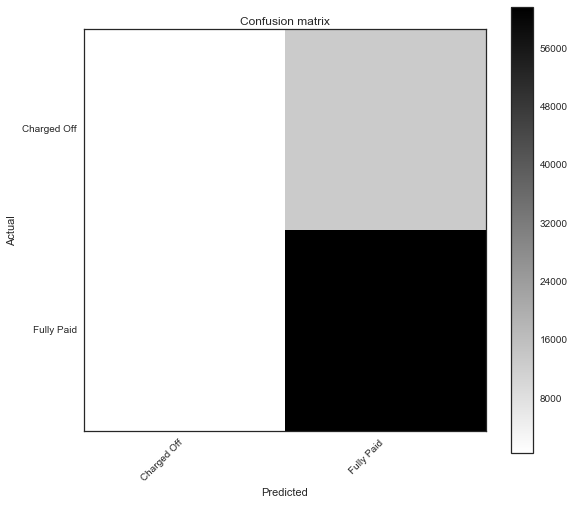

In [78]:
# Logistic Regression all features
clf = LogisticRegression(penalty='l1', C=10)
clf.fit(X_train_scaled, y_train)
prediction = clf.predict(X_test_scaled)

# F1-score
print(f1_score(y_test, prediction, average='weighted'))

# AUC
y_score = clf.predict_proba(X_test_scaled)
fpr2, tpr2, thresholds = roc_curve(np.array(y_test), y_score[:,0], pos_label='Charged Off')
auc2 = round(auc(fpr2, tpr2), 2)
print('auc:', auc2)

# Confusion matrix
confusion_matrix = ConfusionMatrix(np.array(y_test), prediction)
confusion_matrix.print_stats()
confusion_matrix.plot()

0.745158335737
auc: 0.68
Confusion Matrix:

Predicted    Charged Off  Fully Paid  __all__
Actual                                       
Charged Off          203       13335    13538
Fully Paid           313       61981    62294
__all__              516       75316    75832


Overall Statistics:

Accuracy: 0.820023209199
95% CI: (0.81727010898909747, 0.82275180291855388)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.0159888080352
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                               Charged Off  Fully Paid
Population                                  75832       75832
P: Condition positive                       13538       62294
N: Condition negative                       62294       13538
Test outcome positive                         516       75316
Test outcome negative                       75316         516
TP: True Positive                             203       61981
TN: True Negative                           61981         203
FP: Fal

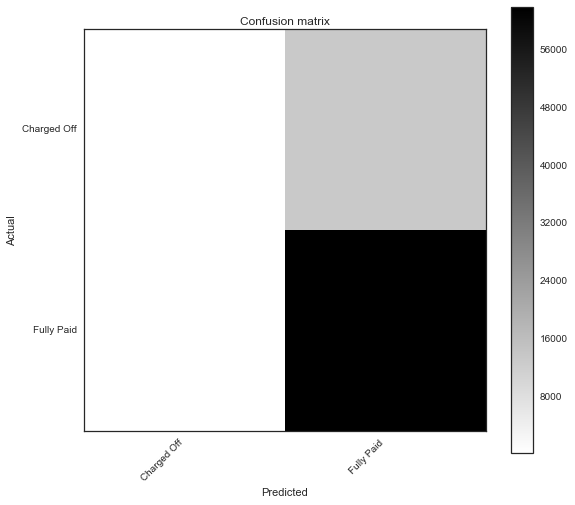

In [73]:
# Logistic Regression top-5 features selected with Select-K-Best
new_X = (SelectKBest(mutual_info_classif, k=5)
        .fit_transform(X_train_scaled, y_train))
clf = LogisticRegression(penalty='l1', C=10)
clf.fit(new_X, y_train)
prediction = clf.predict(X_test_scaled.loc[:, ['term', 'int_rate', 'installment', 'grade', 'sub_grade']])

# F1-score
print(f1_score(y_test, prediction, average='weighted'))

# AUC
y_score = clf.predict_proba(X_test_scaled.loc[:, ['term', 'int_rate', 'installment', 'grade', 'sub_grade']])
fpr3, tpr3, thresholds = roc_curve(np.array(y_test), y_score[:,0], pos_label='Charged Off')
auc3 = round(auc(fpr3, tpr3), 2)
print('auc:', auc3)

# Confusion matrix
confusion_matrix = ConfusionMatrix(np.array(y_test), prediction)
confusion_matrix.print_stats()
confusion_matrix.plot()

0.740959528403
auc: 0.66
Predicted    Charged Off  Fully Paid  __all__
Actual                                       
Charged Off            0       13538    13538
Fully Paid             0       62294    62294
__all__                0       75832    75832


/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


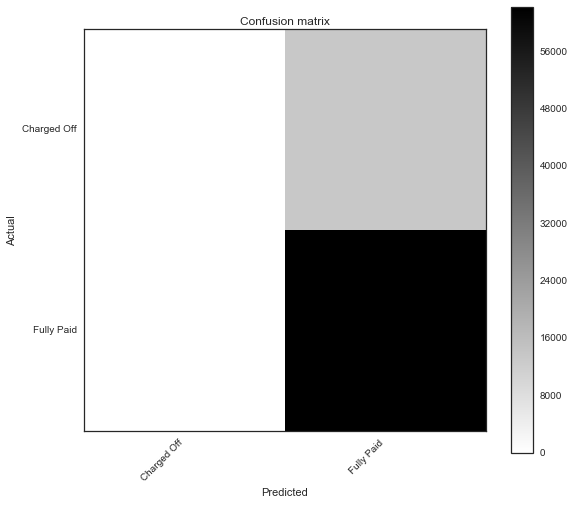

In [76]:
# Random Forest only grade
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train.loc[:,['grade']], y_train)
prediction = clf.predict(X_test.loc[:,['grade']])

# F1-score
print(f1_score(y_test, prediction, average='weighted'))

# AUC
y_score = clf.predict_proba(X_test.loc[:,['grade']])
fpr4, tpr4, thresholds = roc_curve(np.array(y_test), y_score[:,0], pos_label='Charged Off')
auc4 = round(auc(fpr4, tpr4), 2)
print('auc:', auc4)

# Confusion matrix
confusion_matrix = ConfusionMatrix(np.array(y_test), prediction)
print(confusion_matrix)
confusion_matrix.plot()

0.753816127996
auc: 0.7
Predicted    Charged Off  Fully Paid  __all__
Actual                                       
Charged Off          570       12968    13538
Fully Paid           615       61679    62294
__all__             1185       74647    75832


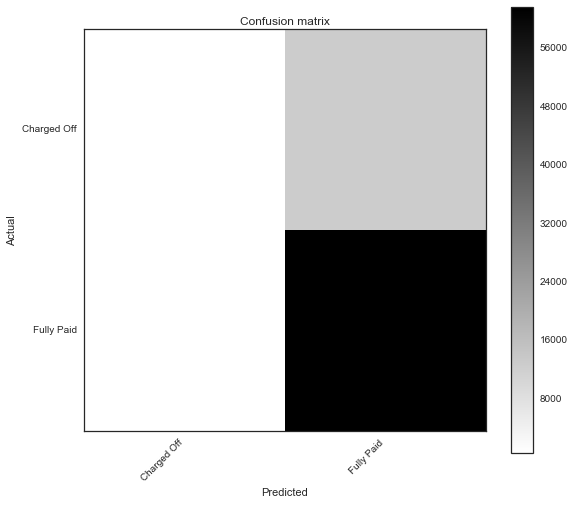

In [75]:
# Random Forest all features
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

# F1-score
print(f1_score(y_test, prediction, average='weighted'))

# AUC
y_score = clf.predict_proba(X_test)
fpr5, tpr5, thresholds = roc_curve(np.array(y_test), y_score[:,0], pos_label='Charged Off')
auc5 = round(auc(fpr5, tpr5), 2)
print('auc:', auc5)

# Confusion matrix
confusion_matrix = ConfusionMatrix(np.array(y_test), prediction)
print(confusion_matrix)
confusion_matrix.plot()

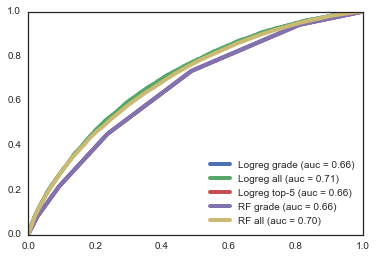

In [79]:
# ROC-plot with AUC scores.

plt.plot(fpr1, tpr1, label='Logreg grade (auc = %0.2f)' % auc1, linewidth=4)
plt.plot(fpr2, tpr2, label='Logreg all (auc = %0.2f)' % auc2, linewidth=4)
plt.plot(fpr3, tpr3, label='Logreg top-5 (auc = %0.2f)' % auc3, linewidth=4)
plt.plot(fpr4, tpr4, label='RF grade (auc = %0.2f)' % auc4, linewidth=4)
plt.plot(fpr5, tpr5, label='RF all (auc = %0.2f)' % auc5, linewidth=4)
plt.legend(loc="lower right")
plt.show()

So adding features does lead to a little better performance. Therefore it is interesting to see which features are mostly used for this increase. The important features for logistic regression can be found by seeing which coefficients are used for the features. The bigger the coefficient the more the model uses this feature for prediction. For our best performing model, Logistic Regression with all features, the top-5 features with the biggest coefficients are: interest rate, annual income, subgrade, term and dti. The first and last two have a negative coefficient and the other two a positive one. It seems that the algorithm choose 'fully paid' as the positive class. Therefore a negative coefficient for interest rate means that the higher the interest rate the smaller the smaller the chance on 'fully paid'. This makes sense since grade is related to interest rate and the higher the grade, the higher the chance on 'charged off'. A shorter time period (term) gives less chance on 'charged off'. This also seems logical. And the less debt to income the less chance on 'charged off, which also makes sense. Grade is not in the top-5 features but the redundant feature subgrade is, only the strange thing is that the algorithm gave it a positive coeficient, hence the higher the subgrade, the more chance on 'fully paid'. This makes no sense. Annual income on the other hand is logical, since more annual income giving a bigger chance on 'fully paid' seems plossible. Subsequently these features were put in a logistic regression model of the package statsmodel to get p-values for the features. Here the sign coefficients are exactly reversed, so it seems to have chosen 'charged off' as the positive class. All the features for which the sign logically makes sense are siginificant, only subgrade is not. Hence this fits with what seems logical. 

In [89]:
clf = LogisticRegression(penalty='l1', C=10)
clf.fit(X_train_scaled, y_train)
coefs = clf.coef_

# find index of top 5 highest coefficients, aka most used features for prediction
positions = abs(coefs[0]).argsort()[-5:][::-1]
features = list(X_train_scaled.columns[positions])
print(features)
print(coefs[0][positions])
print(clf.classes_)

# use statsmodels logistic regression to get p-values for the top-5 most used features
logit = sm.Logit(y_train == 'Charged Off', np.array(X_train_scaled.loc[:, features]))
result = logit.fit()
print(result.summary())

['int_rate', 'annual_inc', 'sub_grade', 'term', 'dti']
[-0.61396632  0.29841595  0.28317704 -0.17347018 -0.15910968]
['Charged Off' 'Fully Paid']
Optimization terminated successfully.
         Current function value: 0.672390
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:               176939
Model:                          Logit   Df Residuals:                   176934
Method:                           MLE   Df Model:                            4
Date:                Fri, 03 Feb 2017   Pseudo R-squ.:                 -0.4312
Time:                        15:08:27   Log-Likelihood:            -1.1897e+05
converged:                       True   LL-Null:                       -83125.
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------

#### Re-creating grade

We saw from the section before that we only slightly outperform an algorithm with only grade by adding more features. Therefore we will see which features are predictive of grade and are in that way important. First a Logistic Regression algorithm is trained to predict the grades. We see that it mostly predicts everything as grade A. And the other grades are also not that well predicted except for G, but there are only 2 G loans. Random Forest on the other hand performs a little better. It also predicts most things as A, but we see some promising coloring on the diagonal (predicting the right grade) and the precision for these grades is around 0.8. The feature importance in Random Forest as implemented by sklearn is determined as total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble. The most important features are found to be: revolving line utilization rate (the amount of credit used compared to all credit), installment (monthly payment), revolving balance (all credit), loan amount and debt-to-income. So the grade seems to be mostly based on the amount borrowed (loan amount and installment) and the debt the borrower already has (revolving_util, revolving_bal, dti). It makes sense that these things might be important. Nevertheless, the recreated algorithm is by far not as good as the one of Lending Club. If we leave out loans with grade A than our algorithm just predicts most things as grade B, while the rest of the grades are a lot more accurate. Either Lending Club trained a way better algorithm and/or Lending Club does not make all characteristics of the loans they use for their algorithm public knowledge.

In [105]:
# split data in train (70%) and test set (30%) stratify by loan_status
X_train, X_test, y_train, y_test = train_test_split(closed_loans_predict.drop(['grade', 'sub_grade', 'int_rate', 'roi', 'loan_status']
                                                                      , axis=1), 
                                                    closed_loans['grade'], test_size=0.3, 
                                                    random_state=123, stratify=closed_loans['loan_status'])

# scaling and normalizing the features
X_train_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# scale test set with scaling used in train set
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# binarize the labels for multiclass onevsall prediction
lb = LabelBinarizer()
grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
lb.fit(grades)
y_train_2 = lb.transform(y_train)

Confusion Matrix:

Predicted      A   B    C    D    E   F  G  __all__
Actual                                             
A          12790   5    3    0    0   0  0    12798
B          22786   7   20    3    0   0  0    22816
C          19439   0   43   27    0   0  0    19509
D          12017   1   42   96    2   0  0    12158
E           5451   0   16  237   16   4  0     5724
F           1836   0    5  297  105   5  0     2248
G            341   0    4  133   97   2  2      579
__all__    74660  13  133  793  220  11  2    75832


Overall Statistics:

Accuracy: 0.170890916763
95% CI: (0.16821786155214871, 0.1735891758885294)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.00280065900501
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                          A            B            C  \
Population                                   75832        75832        75832   
P: Condition positive                        12798        22816        19509  

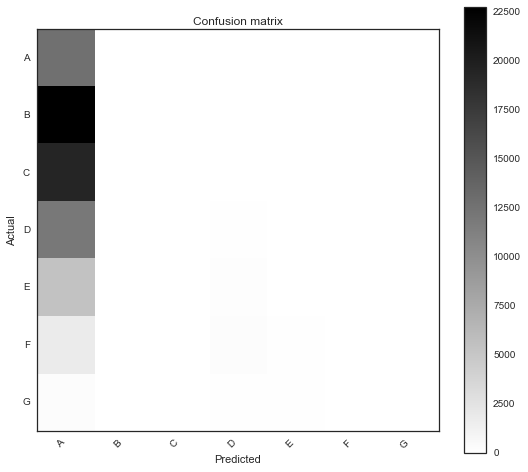

In [99]:
# Logistic Regression predicting grade from the other features (excluding interest rate and subgrade)
clf = OneVsRestClassifier(LogisticRegression(penalty='l1'))
predict_y = clf.fit(X_train_scaled, y_train_2).predict(X_test_scaled)
predict_y = lb.inverse_transform(predict_y)

# confusion matrix
confusion_matrix = ConfusionMatrix(np.array(y_test, dtype='<U1'), predict_y)
confusion_matrix.plot()  
confusion_matrix.print_stats()

Confusion Matrix:

Predicted      A      B     C    D    E    F   G  __all__
Actual                                                   
A          12011    783     3    1    0    0   0    12798
B          13623   8873   315    5    0    0   0    22816
C          15637   1152  2679   41    0    0   0    19509
D          11181     89   397  415   76    0   0    12158
E           5058     12    43  102  489   20   0     5724
F           1933      1    11    8   55  240   0     2248
G            483      0     0    4    5   49  38      579
__all__    59926  10910  3448  576  625  309  38    75832


Overall Statistics:

Accuracy: 0.326313429687
95% CI: (0.32297643957861172, 0.32966371258470151)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.167961978888
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        A          B          C  \
Population                                 75832      75832      75832   
P: Condition positive          

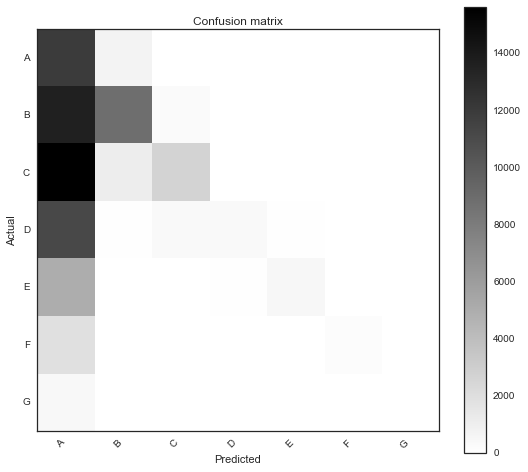

In [106]:
# Random Forest predicting grade from the other features (excluding interest rate and subgrade)
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
predict_y = clf.fit(X_train, y_train_2).predict(X_test)
predict_y = lb.inverse_transform(predict_y)

# confusion matrix
confusion_matrix = ConfusionMatrix(np.array(y_test, dtype='<U1'), predict_y)
confusion_matrix.plot()
confusion_matrix.print_stats()

# important features
features = []
for i,j in enumerate(grades):
    print('\n',j)
    feat_imp = clf.estimators_[i].feature_importances_
    positions = abs(feat_imp).argsort()[-5:][::-1]
    features.extend(list(X_train.columns[positions]))
    print(X_train.columns[positions])
    print(feat_imp[positions])

print(pd.Series(features).value_counts())  

In [103]:
# Excluding loans with grade A
# split data in train (70%) and test set (30%) stratify by loan_status
no_A_loans = closed_loans_predict[closed_loans['grade']!='A']
X_train, X_test, y_train, y_test = train_test_split(no_A_loans.drop(['grade', 'sub_grade', 'int_rate', 'roi', 'loan_status']
                                                                      , axis=1), 
                                                    closed_loans[closed_loans['grade']!='A']['grade'], test_size=0.3, 
                                                    random_state=123, stratify=closed_loans[closed_loans['grade']!='A']['loan_status'])

# scaling and normalizing the features
X_train_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# scale test set with scaling used in train set
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# binarize the labels for multiclass onevsall prediction
lb = LabelBinarizer()
grades = ['B', 'C', 'D', 'E', 'F', 'G']
lb.fit(grades)
y_train_2 = lb.transform(y_train)

Confusion Matrix:

Predicted      B     C    D    E    F   G  __all__
Actual                                            
B          22354   452   11    0    0   0    22817
C          15411  4228   54    0    0   0    19693
D          10806   637  452   74    0   0    11969
E           5142    47  102  484   17   0     5792
F           1933     5   11   73  224   2     2248
G            526     0    2   10   35  54      627
__all__    56172  5369  632  641  276  56    63146


Overall Statistics:

Accuracy: 0.440186235074
95% CI: (0.4363093196364442, 0.44406864839875915)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.137501864391
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        B          C          D  \
Population                                 63146      63146      63146   
P: Condition positive                      22817      19693      11969   
N: Condition negative                      40329      43453      51177   
Test 

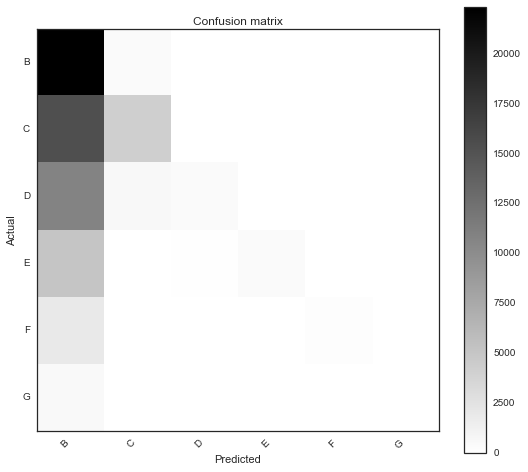

In [104]:
# Excluding loans with grade A
# Random Forest predicting grade from the other features (excluding interest rate and subgrade)
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
predict_y = clf.fit(X_train, y_train_2).predict(X_test)
predict_y = lb.inverse_transform(predict_y)

# confusion matrix
confusion_matrix = ConfusionMatrix(np.array(y_test, dtype='<U1'), predict_y)
confusion_matrix.plot()
confusion_matrix.print_stats()

# important features
features = []
for i,j in enumerate(grades):
    print('\n',j)
    feat_imp = clf.estimators_[i].feature_importances_
    positions = abs(feat_imp).argsort()[-5:][::-1]
    features.extend(list(X_train.columns[positions]))
    print(X_train.columns[positions])
    print(feat_imp[positions])

print(pd.Series(features).value_counts())  

## Discussion

## References

Rpub, Stanford, Wu.